In [1]:
!python --version !pip show tensorflow

Python 3.11.13


In [2]:
!pip install tensorflow

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


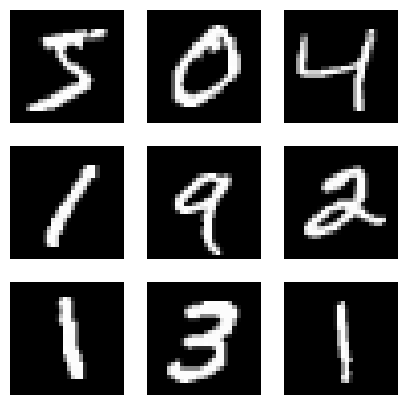

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data (scale pixel values between 0 and 1)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Show sample images
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis('off')
plt.show()

In [6]:
# Define model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)), # Input layer (flatten 28x28 pixels)
    tf.keras.layers.Dense(128, activation='relu'), # Hidden layer
    tf.keras.layers.Dense(10, activation='softmax') # Output layer (10 classes)
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# Save trained model
model.save("mnist_model.h5")
print("Model training complete and saved as mnist_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8802 - loss: 0.4311 - val_accuracy: 0.9595 - val_loss: 0.1298
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9659 - loss: 0.1162 - val_accuracy: 0.9693 - val_loss: 0.0968
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9775 - loss: 0.0766 - val_accuracy: 0.9713 - val_loss: 0.0867
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9825 - loss: 0.0563 - val_accuracy: 0.9726 - val_loss: 0.0836
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9872 - loss: 0.0411 - val_accuracy: 0.9752 - val_loss: 0.0792


Model training complete and saved as mnist_model.h5


In [7]:
# Load trained model
model = tf.keras.models.load_model("mnist_model.h5")

# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open("mnist_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model successfully converted and saved as mnist_model.tflite")

Saved artifact at '/tmp/tmp35lz5191'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137816150995408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137816150989072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137816150994448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137816150993104: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model successfully converted and saved as mnist_model.tflite


In [8]:
# Load TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="mnist_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:", input_details)
print("Output Details:", output_details)

Input Details: [{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([ 1, 28, 28], dtype=int32), 'shape_signature': array([-1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 9, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


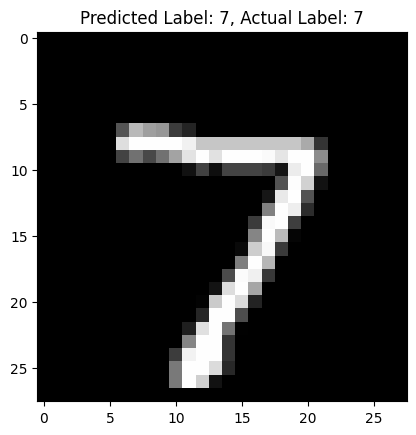

In [9]:
# Select a test image
test_image = x_test[0].astype(np.float32) # Ensure data type matches model input
test_image = np.expand_dims(test_image, axis=0) # Reshape for model input

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], test_image)

# Run inference
interpreter.invoke()

# Get the prediction
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_label = np.argmax(output_data)

# Display the image and prediction
plt.imshow(x_test[0], cmap="gray")
plt.title(f"Predicted Label: {predicted_label}, Actual Label: {y_test[0]}")
plt.show()